In [51]:
import torch
import random

import numpy as np
import torch.nn as nn

from torchsummary import summary

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# Local PC로 실습하는 경우 실행 x / 단 작업경로를 LGES2023_CNN으로 맞춰주기
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/LGES2023_CNN

In [52]:
# 똑같은 결과를 얻기 위한 시드 고정
seed = 2023
torch.manual_seed(seed) # torch cpu seed 고정
torch.cuda.manual_seed(seed) # torch gpu seed 고정
torch.cuda.manual_seed_all(seed) # torch multi-gpu seed 고정
np.random.seed(seed) # numpy seed 고정
random.seed(seed) # python seed 고정

#### Dataset 및 DataLoader 정의

In [53]:
from glob import glob
## train/valid/test split하기
cat_train_path = glob(f'./data/dog_cat/train/cat/*') # train 폴더 cat 이미지 경로
cat_train_labels = [0]*len(cat_train_path) # cat에 대한 레이블 생성

random.shuffle(cat_train_path) # train/valid 분할을 위한 이미지 경로 섞기
cut_index = int(len(cat_train_path) * 0.7) # cat 이미지 중 70%학습으로 사용

# cat 이미지 train/valid 분할
cat_train_path, cat_valid_path = cat_train_path[:cut_index], cat_train_path[cut_index:]
cat_train_labels, cat_valid_labels = cat_train_labels[:cut_index], cat_train_labels[cut_index:]

dog_train_path = glob(f'./data/dog_cat/train/dog/*') # train 폴더 dog 이미지 경로
dog_train_labels = [1]*len(dog_train_path) # dog에 대한 레이블 생성

random.shuffle(dog_train_path) # train/valid 분할을 위한 이미지 경로 섞기
cut_index = int(len(dog_train_path) * 0.7) # dog 이미지 중 70%학습으로 사용

# dog 이미지 train/valid 분할
dog_train_path, dog_valid_path = dog_train_path[:cut_index], dog_train_path[cut_index:]
dog_train_labels, dog_valid_labels = dog_train_labels[:cut_index], dog_train_labels[cut_index:]

# trainset을 위한 cat 이미지 + dog 이미지
train_path = dog_train_path + cat_train_path
train_labels = dog_train_labels + cat_train_labels

# validset을 위한 cat 이미지 + dog 이미지
valid_path = dog_valid_path + cat_valid_path
valid_labels = dog_valid_labels + cat_valid_labels

# test 폴더 이미지 이미지 경로
cat_test_path = glob(f'./data/dog_cat/test/cat/*')
cat_test_labels = [0]*len(cat_test_path)

dog_test_path = glob(f'./data/dog_cat/test/dog/*')
dog_test_labels = [1]*len(dog_test_path)

# testset을 위한 cat 이미지 + dog 이미지
test_path = dog_test_path + cat_test_path
test_labels = dog_test_labels + cat_test_labels

print(f'trainset 이미지 수 : {len(train_path)}')
print(f'validset 이미지 수 : {len(valid_path)}')
print(f'testset 이미지 수  : {len(test_path)}')

trainset 이미지 수 : 140
validset 이미지 수 : 62
testset 이미지 수  : 102


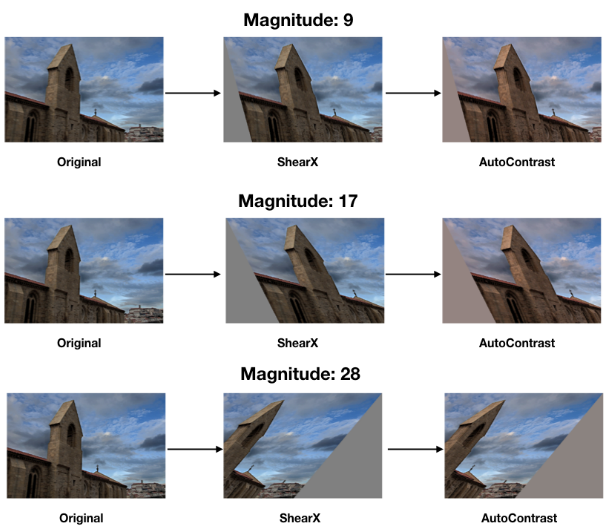

In [1]:
from PIL import Image
Image.open('./images/img8.png')

In [54]:

    # CatDogDataset
import torchvision.transforms as tf
from torch.utils.data import Dataset, DataLoader

class CatDogDataset(Dataset):
    def __init__(self, img_path, labels, mode):

      if mode == 'train':
        self.transform = tf.Compose([
                                    # tf.ToPILImage(), 만약 데이터가 array나 tensor로 되어 있는 경우 PILImage로 변경이 필요
                                    tf.RandAugment(num_ops=2, magnitude=9),
                                    tf.Resize(size=(128,128)),
                                    tf.ToTensor()
                                    # tf.Normalize(mean=(0.0,0.0,0.0), std=(1.,1.,1.)), RGB의 평균과 분산을 알고 있는 경우 정규화
                                                  ])
      else: # valid or test
        self.transform = tf.Compose([
                                    tf.Resize(size=(128,128)),
                                    tf.ToTensor(),
                                    # tf.Normalize(mean=(0.0,0.0,0.0), std=(1.,1.,1.))
                                     ])
        
      self.img_path =img_path
      self.labels = labels

    def __len__(self):
      return len(self.img_path)
    def __getitem__(self,idx):
      crt_img_path = self.img_path[idx] # 특정 이미지의 경로 선택
      img = Image.open(crt_img_path) # 이미지 오픈
      X = self.transform(img) # 이미지 변형
      
      y = self.labels[idx]
      
      return X, y

In [55]:
# 학습/테스트 데이터셋 및 데이터로더 생성
trainset = CatDogDataset(img_path=train_path, 
                         labels=train_labels,
                         mode='train')

validset = CatDogDataset(img_path=valid_path, 
                         labels=valid_labels,
                         mode='valid')

testset = CatDogDataset(img_path=test_path, 
                         labels=test_labels,
                         mode='test')

trainloader = DataLoader(dataset=trainset, 
                         batch_size=64,
                         shuffle=True,
                         drop_last=False)

validloader = DataLoader(dataset=validset, 
                         batch_size=64,
                         shuffle=False,
                         drop_last=False)

testloader = DataLoader(dataset=testset, 
                         batch_size=64,
                         shuffle=False,
                         drop_last=False)

#### CNN모델 정의: LeNet5을 고해상도 이미지에 맞게 좀 더 깊게 변형

kernel size를 줄이면 파라미터 효율이 좋아지고 깊은 모델을 만들 수 있음

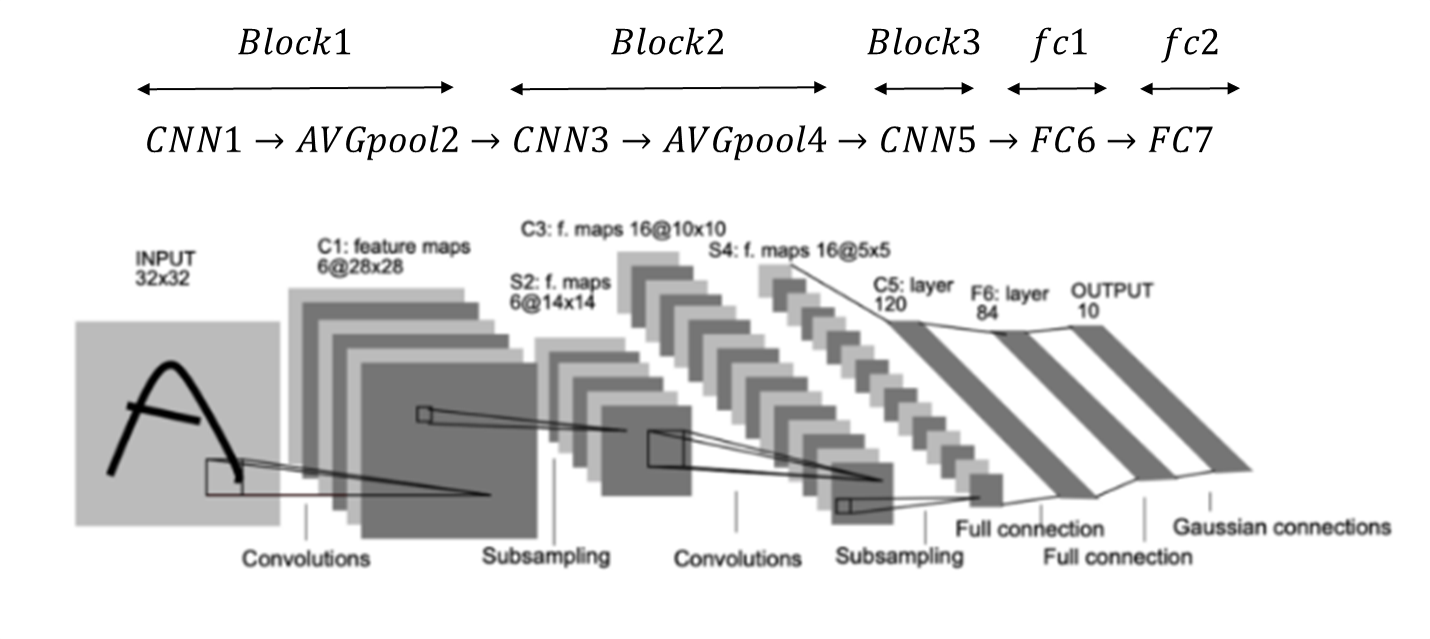

In [56]:
# LeNet5 구조
Image.open('./images/img4.png')

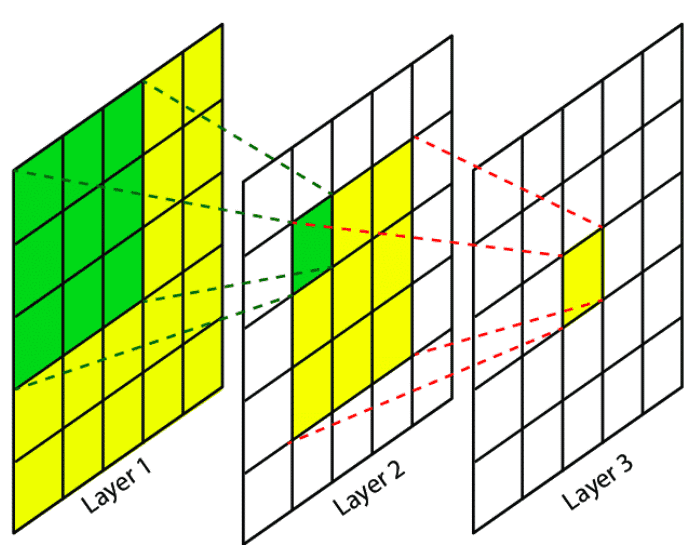

In [73]:
# receptive field of CNNs
Image.open('./images/img7.png')

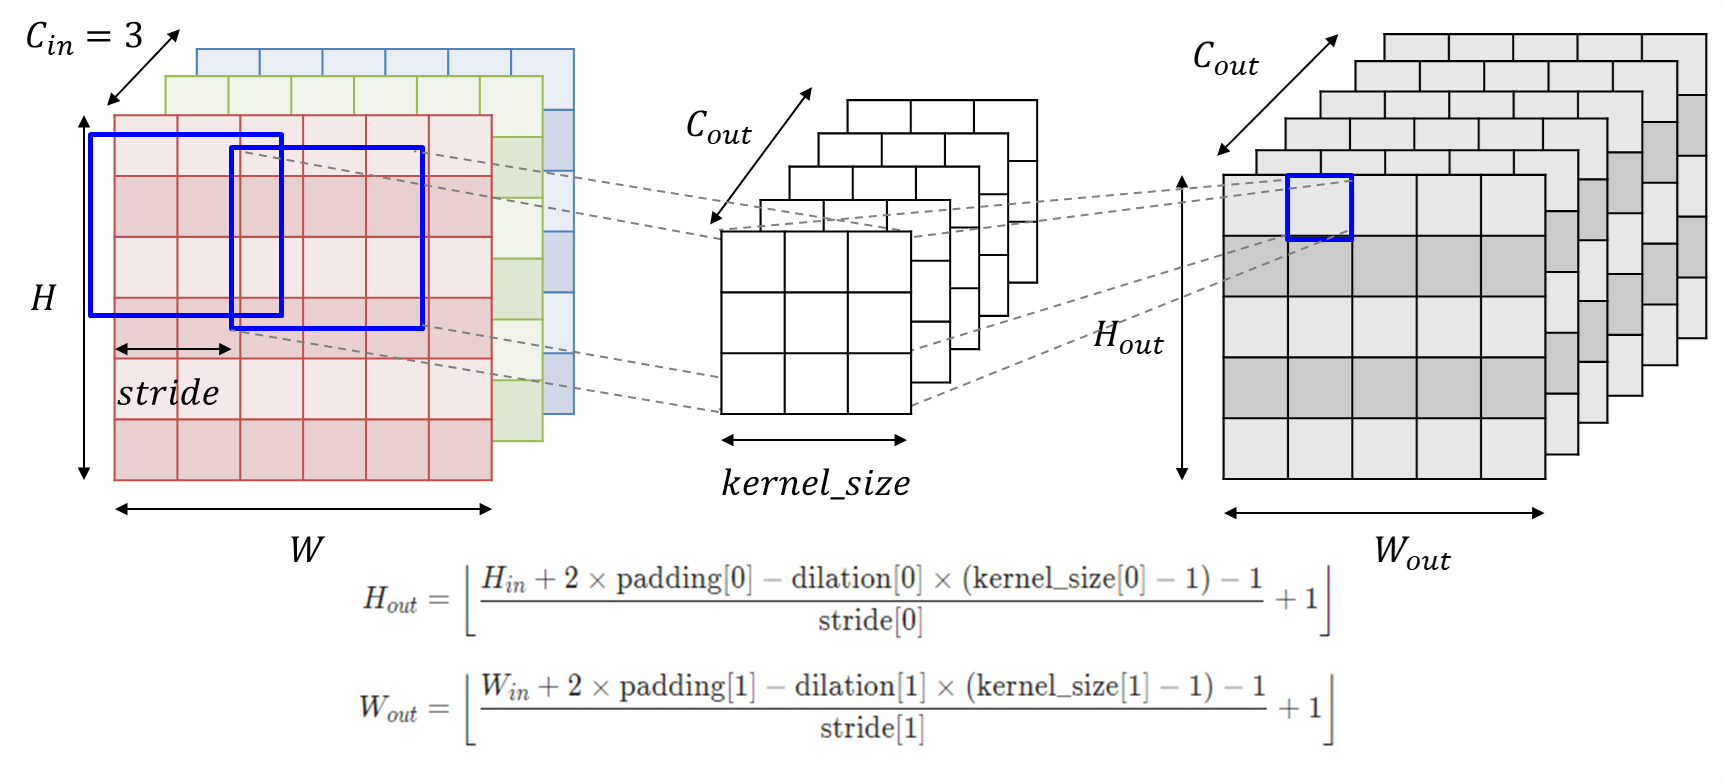

In [57]:
# convolution layer
Image.open('./images/img2.png')

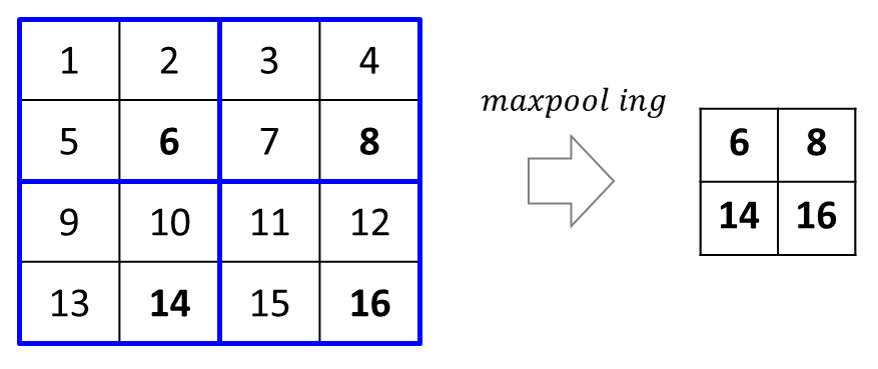

In [58]:
# pooling
Image.open('./images/img3.png')

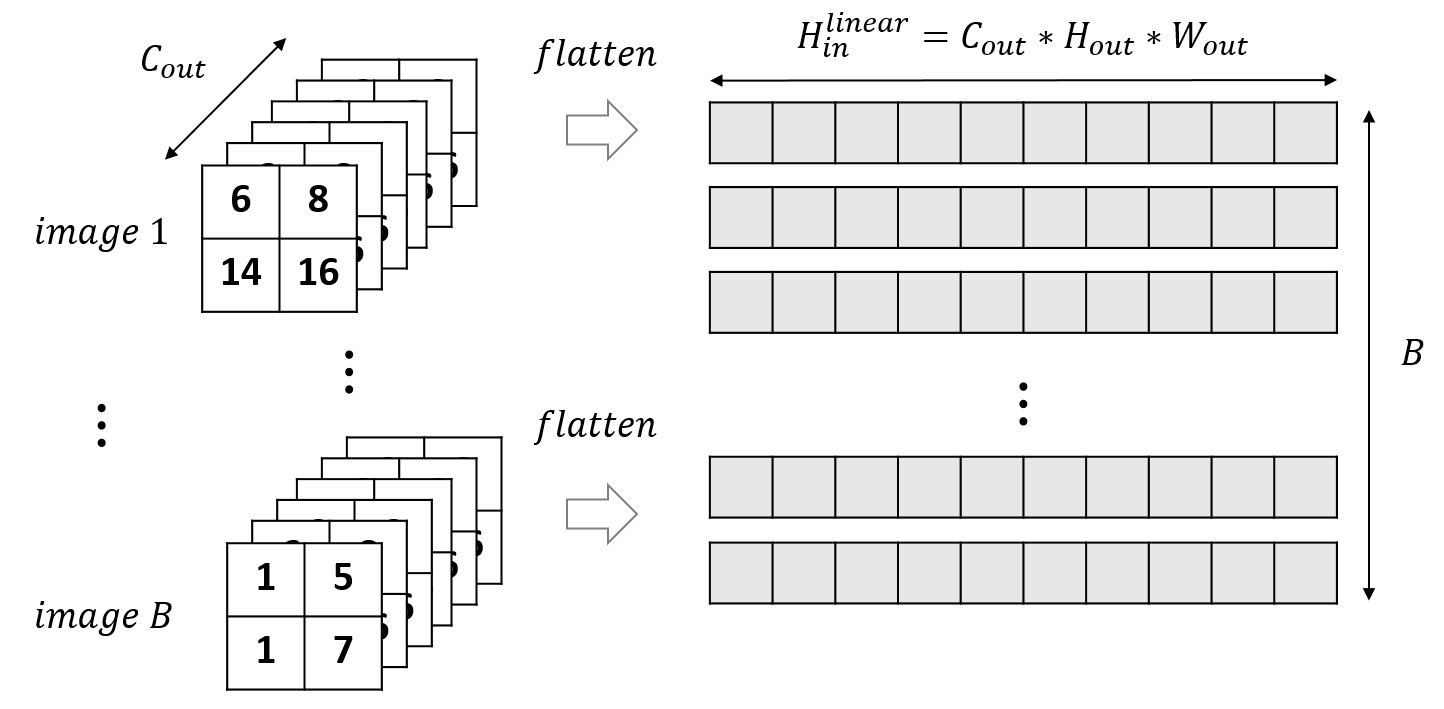

In [59]:
# flatten
Image.open('./images/img5.png')

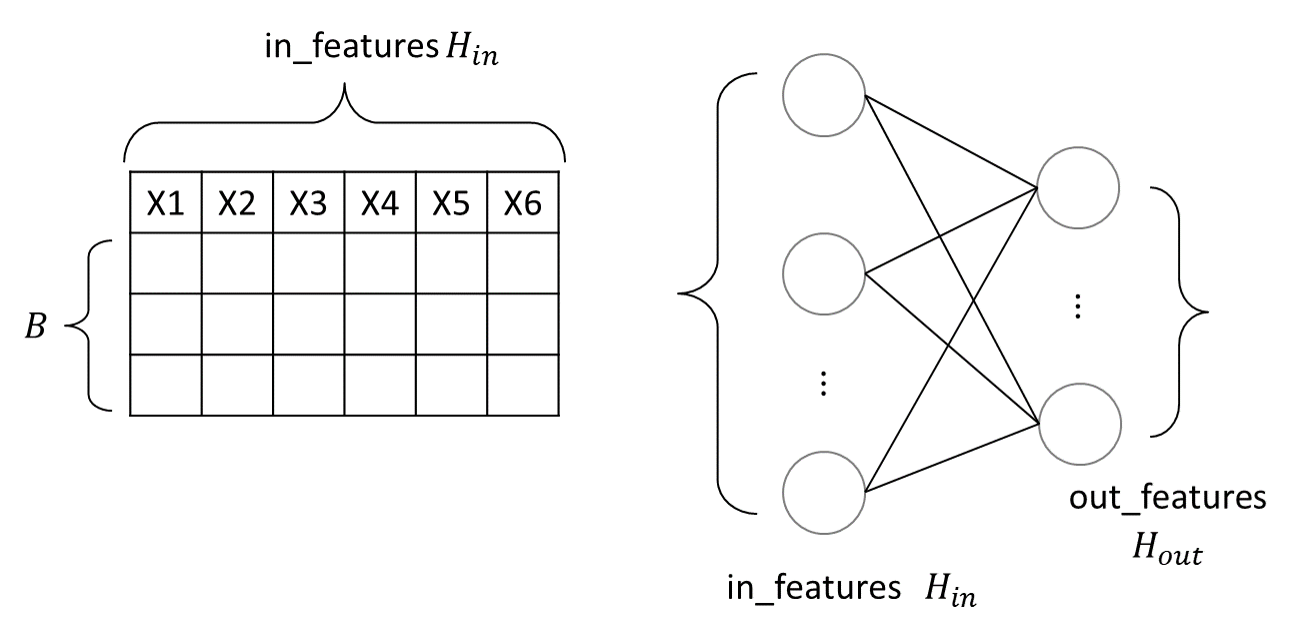

In [60]:
# linear layer
Image.open('./images/img1.png')

In [61]:
class MyLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.block1 = nn.Sequential(
                           nn.Conv2d(in_channels=3,out_channels=16,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
                           nn.BatchNorm2d(num_features=16),
                           nn.ReLU(True),
                           nn.MaxPool2d(kernel_size=(2,2),stride=(2,2), padding=(0,0)))
        
        self.block2 = nn.Sequential(
                           nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
                           nn.BatchNorm2d(num_features=32),
                           nn.ReLU(True),
                           nn.MaxPool2d(kernel_size=(2,2),stride=(2,2), padding=(0,0)))
        
        self.block3 = nn.Sequential(
                            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
                            nn.BatchNorm2d(num_features=64),
                            nn.ReLU(True),
                           nn.MaxPool2d(kernel_size=(2,2),stride=(2,2), padding=(0,0)))
        
        self.block4 = nn.Sequential(
                            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
                            nn.BatchNorm2d(num_features=128),
                            nn.ReLU(True),
                            nn.MaxPool2d(kernel_size=(2,2),stride=(2,2), padding=(0,0)))
        
        self.block5 = nn.Sequential(
                            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
                            nn.BatchNorm2d(num_features=128),
                            nn.ReLU(True),
                            nn.MaxPool2d(kernel_size=(2,2),stride=(2,2), padding=(0,0)))
        
        self.fc1 = nn.Sequential(nn.Linear(128*4*4,128), nn.ReLU(True))
        self.fc2 = nn.Linear(128,num_classes)
        
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)
        
        self.init_weights()
        
    def forward(self, x):
        # x : B, 3, 128, 128
        out = self.block1(x) # B, 16, 64, 64
        out = self.block2(out) # B, 32, 32, 32
        out = self.block3(out) # B, 64, 16, 16
        out = self.block4(out) # B, 128, 8, 8
        out = self.block5(out) # B, 128, 4, 4
        out = self.flatten(out) # B, 128*4*4
        out = self.fc1(out) # B, 128
        out = self.fc2(out) # B, num_classes
        
        return out
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)

In [63]:
model = MyLeNet(num_classes=2)
summary(model, input_size=(3,128,128), device='cpu')

#### Optimizer 정의

optimizer 종류 : https://pytorch.org/docs/stable/optim.html

In [64]:
# loss.backward를 통해서 gradient를 계산하고 실제로 파라미터를 업데이트 하는 역할

sgd = torch.optim.SGD(params=model.parameters(), # 최적화 할 모델 파라미터
                      lr=0.01, # 학습률
                      momentum=0.9 # 과거 그레디언트 가중합 파라미터
                      # weight_decay=5e-4, l2 정규화 강도 파라미터
                      )

adam = torch.optim.Adam(params=model.parameters(), # 최적화 할 모델 파라미터
                      lr=0.01 # 학습률
                      # betas=(0.9,0.999) # (momentum, adaptive lr momentum)
                      # weight_decay=5e-4, l2 정규화 강도 파라미터
                      )

del sgd, adam

optimizer = torch.optim.SGD(params=model.parameters(),
                      lr=0.001,
                      momentum=0.9,
                      weight_decay=5e-4 # parameter값이 너무 커지지 않도록 규제 
                      )

#### Loss 함수 정의

loss function 종류 : https://pytorch.org/docs/stable/nn.html (검색 ->Loss functions)

In [65]:
mse_fn = nn.MSELoss()
nll_loss = nn.NLLLoss() # Negative log-likelihood loss
ce_fn = nn.CrossEntropyLoss()
bce_fn = nn.BCELoss() # Binary cross-entropy loss

del mse_fn, ce_fn, bce_fn

# 출력 노드를 2개로 했기 때문에 BCE loss를 쓰려면 shape을 따로 맞춰줘야 함
loss_fn = nn.CrossEntropyLoss() 

#### To Device

In [66]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
# 모델 파라미터를 device로 이동
model.to(device)

# loss function을 device로 이동
loss_fn.to(device)

CrossEntropyLoss()

#### 역전파 알고리즘

In [67]:
import time

epochs = 100
best_acc = 0.
train_history = {'loss':[],'acc':[]}
valid_history = {'loss':[],'acc':[]}

for epoch in range(epochs): # 학습 데이터셋 전체를 몇 번 학습시킬건지
    
    # epoch마다 학습이 어떻게 진행되는지 추적하기 위한 변수
    train_loss, valid_loss = 0.0, 0.0
    train_acc, valid_acc = 0.0, 0.0
    n_train, n_valid = 0, 0
    start = time.time()
    
    # training
    model.train() # batchnorm, dropout 등 train할 때와 test할 때 연산이 다른 경우가 존재
    for (imgs, targets) in trainloader: # 학습 데이터셋에서 batch size만큼 가져오기
        
        # 두 텐서를 모델, 목적함수와 같은 device로
        imgs = imgs.to(device) # B,3,32,32
        targets = targets.to(device) # B
        
        # forward
        outputs = model(imgs) # B,2
        
        # loss 계산
        loss = loss_fn(outputs, targets)
        
        # optimizer gradient 초기화
        optimizer.zero_grad()
        
        # backward : gradient 계산
        loss.backward()
        
        # model weight update
        optimizer.step()
        
        # loss 저장
        train_loss += loss.item()
        
        # 맞게 예측한 개수 및 배치 데이터 개수 저장
        preds = torch.max(outputs.detach(), dim=-1)[1] # B
        acc = torch.eq(preds,targets).sum().cpu().item()
        train_acc += acc
        n_train += targets.shape[0]
    
    # 현재 에폭 평균 학습 loss와 accuracy 계산
    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / n_train
    
    # validation : 에폭마다 validset으로 평가를 진행해 모델의 일반화 성능이 어느정도인지 확인
    model.eval() # batchnorm, dropout 등 train할 때와 test할 때 연산이 다른 경우가 존재
    with torch.no_grad():
        for (imgs, targets) in validloader:
            imgs = imgs.to(device) # B,3,32,32
            targets = targets.to(device) # B
            
            outputs = model(imgs) # B,2
            
            loss = loss_fn(outputs, targets)

            # loss 저장
            valid_loss += loss.item()
            
            # 정확도 저장
            preds = torch.max(outputs, dim=-1)[1] # B
            acc = torch.eq(preds,targets).sum().cpu().item()
            valid_acc += acc
            n_valid += targets.shape[0]
    
    # 현재 에폭 평균 테스트 loss와 accuracy 계산
    valid_loss = valid_loss / len(validloader)
    valid_acc = valid_acc / n_valid
    
    # best model일 경우 모델 저장
    if valid_acc > best_acc:
        best_acc = valid_acc
        best_epoch = epoch+1
        save_dict = {'model':model.state_dict(),
                     'optimizer':optimizer.state_dict(),
                     'epoch':best_epoch,
                     'acc':best_acc}
        torch.save(save_dict, './results/catdog_lenet.pt')
        
    # 학습/테스트에 소요된 시간 계산
    epoch_time = time.time() - start
    
    # 학습 정보 출력
    print(f'Epoch     : {epoch+1:6} | Time     : {epoch_time:.2f} sec')
    print(f'Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}')
    print(f'Train ACC : {train_acc:.4f} | Valid ACC : {valid_acc:.4f} \n')

    # 에폭별 학습 정보 저장
    train_history['loss'].append(train_loss)
    train_history['acc'].append(train_acc)
    valid_history['loss'].append(valid_loss)
    valid_history['acc'].append(valid_acc)


# 학습 종료
print('-'*50)
print('Dataset  : DogCat | Model : LeNet5')
print(f'Best ACC : {best_acc:.4f} | Best Epoch : {best_epoch}')
    

Epoch     :      1 | Time     : 0.73 sec
Train Loss: 1.0280 | Valid Loss: 0.7283
Train ACC : 0.5000 | Valid ACC : 0.5000 

Epoch     :      2 | Time     : 0.57 sec
Train Loss: 0.8652 | Valid Loss: 0.7794
Train ACC : 0.5286 | Valid ACC : 0.5000 

Epoch     :      3 | Time     : 0.55 sec
Train Loss: 0.6618 | Valid Loss: 0.7359
Train ACC : 0.6214 | Valid ACC : 0.5000 

Epoch     :      4 | Time     : 0.60 sec
Train Loss: 0.7639 | Valid Loss: 0.8085
Train ACC : 0.5929 | Valid ACC : 0.5000 

Epoch     :      5 | Time     : 0.63 sec
Train Loss: 0.5449 | Valid Loss: 0.9257
Train ACC : 0.6786 | Valid ACC : 0.5000 

Epoch     :      6 | Time     : 0.59 sec
Train Loss: 0.6392 | Valid Loss: 0.8508
Train ACC : 0.6286 | Valid ACC : 0.5000 

Epoch     :      7 | Time     : 0.62 sec
Train Loss: 0.6348 | Valid Loss: 0.7802
Train ACC : 0.6571 | Valid ACC : 0.5000 

Epoch     :      8 | Time     : 0.63 sec
Train Loss: 0.4891 | Valid Loss: 0.7975
Train ACC : 0.7786 | Valid ACC : 0.5000 

Epoch     :     

#### 학습 추세 시각화

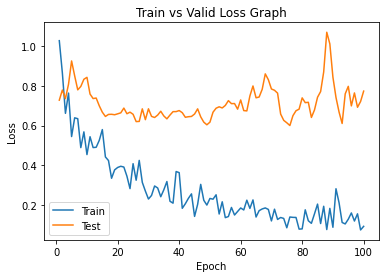

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x=range(1,epochs+1),y=train_history['loss'], label='Train')
sns.lineplot(x=range(1,epochs+1),y=valid_history['loss'], label='Test')
plt.title('Train vs Valid Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

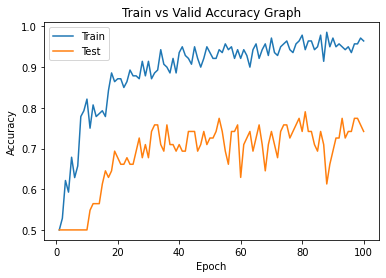

In [69]:
sns.lineplot(x=range(1,epochs+1),y=train_history['acc'], label='Train')
sns.lineplot(x=range(1,epochs+1),y=valid_history['acc'], label='Test')
plt.title('Train vs Valid Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#### Testset을 통한 최종 모델 성능평가

In [70]:
# 저장된 모델 load / 모델 구조를 불러온 뒤 parameter를 해당 레이어로 load해줘야함
test_model = MyLeNet(num_classes=2) # 모델 구조 선억
load_dict = torch.load('./results/catdog_lenet.pt', map_location='cpu')
parameters = load_dict['model'] 
test_model.load_state_dict(parameters,strict=False)

# to device
test_model.to(device)

MyLeNet(
  (block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Co

In [71]:
# test
test_acc = 0.0
n_test = 0
model.eval()
with torch.no_grad():
    for (imgs, targets) in testloader:
        imgs = imgs.to(device) # B,3,32,32
        targets = targets.to(device) # B
        
        outputs = model(imgs) # B,2
        
        # max함수를 통한 예측값 생성
        preds = torch.max(outputs, dim=-1)[1] # B
        acc = torch.eq(preds,targets).sum().cpu().item()
        test_acc += acc
        n_test += targets.shape[0]

# accuracy 계산
test_acc = test_acc / n_test

# 학습 정보 출력
print(f'Data      : dog_cat')
print(f'Seed      : {seed}')
print(f'Model     : LeNet5')
print(f'valid ACC : {load_dict["acc"]:.4f}')
print(f'test ACC  : {test_acc:.4f} \n')


Data      : dog_cat
Seed      : 2023
Model     : LeNet5
valid ACC : 0.7903
test ACC  : 0.7059 

